# Sentinel 2 Access

Select, access and download Sentinel-2 images.

## Setup

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import geopandas as gpd

In [4]:
from shapely.geometry import shape
from shapely import wkt
from shapely.ops import unary_union

In [5]:
import json

In [6]:
import requests

In [7]:
from hda import Client as hda_client

In [8]:
from pystac_client import Client

In [9]:
DATA_DIR = '../data/'
FIGURES_DIR = '../saved_figures/'

In [10]:
catalog = Client.open("https://earth-search.aws.element84.com/v1") 

## Subset rectangles

In [11]:
with open(os.path.join(DATA_DIR, 'tile_buffer_wkt.json'), 'r') as f:
    tiles_wkt_dict = json.load(f)

In [12]:
utm = list(tiles_wkt_dict.keys())

In [13]:
utm

['29UPR',
 '30UUA',
 '30UVA',
 '30UVB',
 '30UWB',
 '30UXA',
 '30UVC',
 '30UUC',
 '30UUD',
 '30UUE',
 '30UVE',
 '30UUF',
 '30UVF',
 '30UUG',
 '29UPB',
 '30VUH',
 '30VUJ',
 '30VUK',
 '30VVK',
 '30VVL',
 '30VWL',
 '29VPC',
 '29VPD',
 '29VPE',
 '32UMF',
 '32UNF',
 '32UNG',
 '32UPF',
 '32UPG',
 '32VPK']

In [14]:
len(utm)

30

## Data search

In [15]:
# years = range(2018, 2025)
years = [2020]

In [17]:
start_md = "06-01"
end_md = "08-31"

In [18]:
data_selection = []

In [ ]:
for tileId in tiles_wkt_dict:
    gdf_tiles = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_wkt(tiles_wkt_dict[tileId]), crs="EPSG:4326")
    # bounds = gdf_tiles.total_bounds
    tile_geom = unary_union(gdf_tiles.geometry)
    
    for year in years:
    
        date_query = f"{year}-{start_md}/{year}-{end_md}"
        
        search = catalog.search(
            collections=["sentinel-2-l1c"],
            # bbox=bounds,
            intersects=tile_geom,
            datetime=date_query,
            max_items=30,
            query=[f"grid:code=MGRS-{tileId}"],
            sortby="properties.eo:cloud_cover"
            # sortby=[{"field": "eo:cloud_cover", "direction": "asc"}]
        )
    
        # results = pd.DataFrame.from_dict(search.items_as_dicts())
        results = list(search.get_items())
        print(f"tileId: {tileId}, Year: {year}, Num results: {len(results)}")
    
        scored = []
        for item in results:
            props = item.properties
            geom = shape(item.geometry)
            intersection = tile_geom.intersection(geom)
            overlap_frac = intersection.area / tile_geom.area if not intersection.is_empty else 0.0
            score = (1 - overlap_frac) * 100
            scored.append((item, score))
    
        scored.sort(key=lambda x: x[1])
        item, score = scored[0]
    
        data_selection.append({'tileId': tileId, 'year': year, 'datetime': item.properties.get('datetime')})

In [ ]:
# for tileId in tiles_wkt_dict:
#     gdf_tiles = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_wkt(tiles_wkt_dict[tileId]), crs="EPSG:4326")
#     bounds = gdf_tiles.total_bounds
    
#     for year in years:
#         date_query = f"{year}-{start_md}/{year}-{end_md}"
        
#         search = catalog.search(
#             collections=["sentinel-2-l1c"],
#             bbox=bounds,
#             datetime=date_query,
#             max_items=1,
#             query=[f"grid:code=MGRS-{tileId}"],
#             sortby="properties.eo:cloud_cover"
#         )

#         results = pd.DataFrame.from_dict(search.items_as_dicts())
#         print(f"tileId: {tileId}, Year: {year}, Num results: {len(results)}")

#         for item in search.items_as_dicts():
#             data_selection.append({'tileId': tileId, 'year': year, 'uri': item['properties']['s2:product_uri']})

In [101]:
results['properties'].values[0]

{'created': '2024-06-29T09:35:47.089Z',
 'platform': 'sentinel-2a',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'eo:cloud_cover': 0.00773388276747589,
 'proj:epsg': 32632,
 'mgrs:utm_zone': 32,
 'mgrs:latitude_band': 'V',
 'mgrs:grid_square': 'PK',
 'grid:code': 'MGRS-32VPK',
 'view:sun_azimuth': 167.420526663503,
 'view:sun_elevation': 54.7886256347335,
 's2:degraded_msi_data_percentage': 0.0223,
 's2:product_type': 'S2MSI1C',
 's2:processing_baseline': '05.10',
 's2:product_uri': 'S2A_MSIL1C_20240625T103631_N0510_R008_T32VPK_20240625T142035.SAFE',
 's2:generation_time': '2024-06-25T14:20:35.000000Z',
 's2:datatake_id': 'GS2A_20240625T103631_047052_N05.10',
 's2:datatake_type': 'INS-NOBS',
 's2:datastrip_id': 'S2A_OPER_MSI_L1C_DS_2APS_20240625T142035_S20240625T103955_N05.10',
 's2:granule_id': 'S2A_OPER_MSI_L1C_TL_2APS_20240625T142035_A047052_T32VPK_N05.10',
 's2:reflectance_conversion_factor': 0.968156483239709,
 'datetime': '2024-06-25T10:44:46.164000Z',
 's2:sequence'

In [ ]:
selection_df = pd.DataFrame.from_dict(data_selection)

In [ ]:
selection_df

In [ ]:
selection_df.to_csv(os.path.join(DATA_DIR, 's2_tile_dates.csv'))

## Download images with hda

In [15]:
dates_df = pd.read_csv(os.path.join(DATA_DIR, 's2_tile_dates.csv')).drop(columns=['Unnamed: 0'])

In [16]:
dates_df

,tileId,year,datetime
0,29UPB,2020,2020-08-13T11:46:04.994000Z
1,29UPR,2020,2020-06-21T11:37:34.476000Z
2,29VPC,2023,2023-06-04T11:43:49.024000Z
3,29VPD,2019,2019-06-28T11:54:09.024000Z
4,29VPE,2022,2022-08-31T11:53:59.024000Z
5,30UUA,2020,2020-06-23T11:27:28.873000Z
6,30UUC,2020,2020-06-01T11:37:01.130000Z
7,30UUD,2020,2020-06-01T11:33:31.024000Z
8,30UUE,2020,2020-06-01T11:36:32.869000Z
9,30UUF,2020,2020-06-01T11:36:18.636000Z


In [17]:
def download_image_hda(tileId, startdate, enddate, download_dir):
    c = hda_client()
    
    q = {
        "dataset_id": "EO:ESA:DAT:SENTINEL-2",
        "startdate": f"{startdate}",
        "enddate": f"{enddate}",
        "processingLevel": "S2MSI1C",
        "tileId": f"{tileId}"
    }
    os.makedirs(download_dir, exist_ok=True)
    
    try:
        r = c.search(q)
        r[0].download(download_dir)
        print(f"Downloaded for tile {tileId}")
    except Exception as e:
        print(f"Error downloading for tile {tileId}")
        print(e)

In [18]:
from datetime import datetime, timedelta

In [19]:
for index, row in dates_df.iterrows():
    tileId = row['tileId']
    download_dir = os.path.join(DATA_DIR, f's2_downloads/{tileId}/')

    date_str = row['datetime'][:10].replace('-', '')  # yyyy-mm-dd -> yyyymmdd
    
    if os.path.isdir(download_dir):
        existing_files = os.listdir(download_dir)
        if any(date_str in fname for fname in existing_files):
            print(f"Skipping {tileId}: file already exists.")
            continue  # skip if already downloaded
    startdate = row['datetime'][:10]
    startdate_elem = datetime.strptime(startdate, '%Y-%m-%d')
    enddate_elem = startdate_elem + timedelta(days=1)
    enddate = enddate_elem.strftime('%Y-%m-%d')
    print(f"Downloading {tileId} for {date_str}")
    download_image_hda(tileId, startdate, enddate, download_dir)

Skipping 29UPB: file already exists.
Skipping 29UPR: file already exists.
Skipping 29VPC: file already exists.
Skipping 29VPD: file already exists.
Skipping 29VPE: file already exists.
Skipping 30UUA: file already exists.
Skipping 30UUC: file already exists.
Skipping 30UUD: file already exists.
Skipping 30UUE: file already exists.
Skipping 30UUF: file already exists.
Skipping 30UUG: file already exists.
Skipping 30UVA: file already exists.
Skipping 30UVB: file already exists.
Skipping 30UVC: file already exists.
Skipping 30UVE: file already exists.
Skipping 30UVF: file already exists.
Skipping 30UWB: file already exists.
Skipping 30UXA: file already exists.
Skipping 30VUH: file already exists.
Skipping 30VUJ: file already exists.
Skipping 30VUK: file already exists.
Skipping 30VVK: file already exists.
Skipping 30VVL: file already exists.
Skipping 30VWL: file already exists.
Skipping 32UMF: file already exists.
Skipping 32UNF: file already exists.
Skipping 32UNG: file already exists.
S

In [20]:
# After running download process once, some tiles might be affected by cloud or low coverage
tiles_redo = ['30VUH', '30VUJ', '29VPD', '29VPC', '29VPE']

In [21]:
import shutil

In [22]:
for tileId in tiles_redo:
    download_dir = os.path.join(DATA_DIR, f's2_downloads/{tileId}/')
    dt = dates_df[dates_df['tileId'] == tileId]['datetime'].values[0]
    date_str = dt[:10].replace('-', '')
    files_and_folders = os.listdir(download_dir)

    for f in files_and_folders:
        full_path = os.path.join(download_dir, f)
        if date_str not in f:
            if os.path.isdir(full_path):
                shutil.rmtree(full_path)
            else:
                os.remove(full_path)

## Unzip SAFE files

In [23]:
import zipfile

In [24]:
os.listdir(os.path.join(DATA_DIR, 's2_downloads/30UUA'))

['S2B_MSIL1C_20200623T112119_N0500_R037_T30UUA_20230427T164710.zip',
 'S2B_MSIL1C_20200623T112119_N0500_R037_T30UUA_20230427T164710.SAFE']

In [25]:
for tileId in utm:
    print(f"Unzipping for tile {tileId}")
    download_dir = os.path.join(DATA_DIR, f's2_downloads/{tileId}/')
    safe_fns = [x for x in os.listdir(download_dir) if x.endswith('.SAFE')]

    if len(safe_fns) > 0:  # already unzipped
        continue
    
    try:
        zip_fn = [x for x in os.listdir(download_dir) if x.endswith('.zip')][0]
        zip_fp = os.path.join(download_dir, zip_fn)
        with zipfile.ZipFile(zip_fp) as zf:
            zf.extractall(download_dir)
    except Exception as e:
        print(f"Error with tile {tileId}: {e}")

Unzipping for tile 29UPR
Unzipping for tile 30UUA
Unzipping for tile 30UVA
Unzipping for tile 30UVB
Unzipping for tile 30UWB
Unzipping for tile 30UXA
Unzipping for tile 30UVC
Unzipping for tile 30UUC
Unzipping for tile 30UUD
Unzipping for tile 30UUE
Unzipping for tile 30UVE
Unzipping for tile 30UUF
Unzipping for tile 30UVF
Unzipping for tile 30UUG
Unzipping for tile 29UPB
Unzipping for tile 30VUH
Unzipping for tile 30VUJ
Unzipping for tile 30VUK
Unzipping for tile 30VVK
Unzipping for tile 30VVL
Unzipping for tile 30VWL
Unzipping for tile 29VPC
Unzipping for tile 29VPD
Unzipping for tile 29VPE
Unzipping for tile 32UMF
Unzipping for tile 32UNF
Unzipping for tile 32UNG
Unzipping for tile 32UPF
Unzipping for tile 32UPG
Unzipping for tile 32VPK


## Display image previews

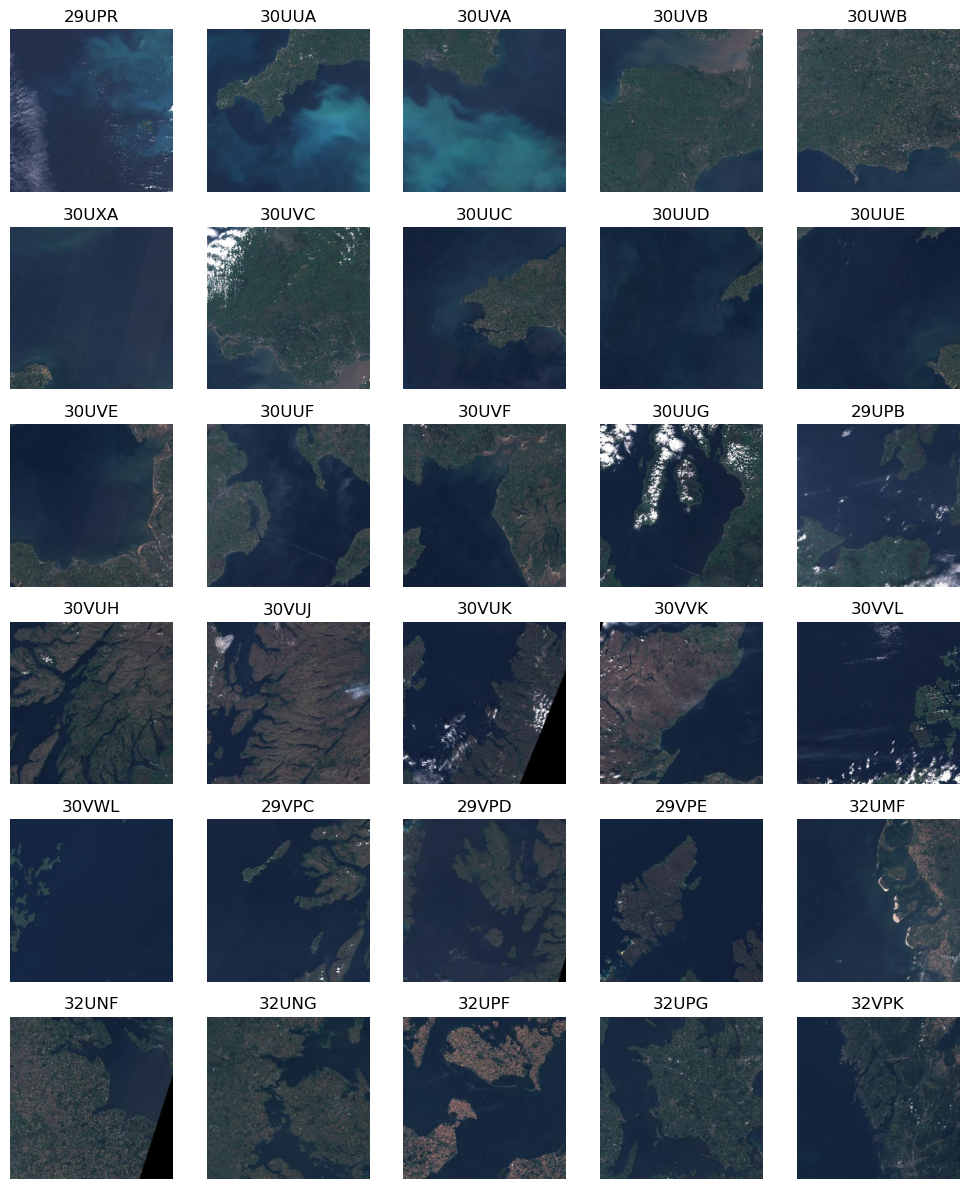

In [26]:
fig, axes = plt.subplots(6, 5, figsize=(10, 12))

for i, tileId in enumerate(utm):
    x = i % 5
    y = i // 5

    download_dir = os.path.join(DATA_DIR, f's2_downloads/{tileId}/')
    safe_name = [x for x in os.listdir(download_dir) if x.endswith('.SAFE')][0]
    safe_dir = os.path.join(download_dir, safe_name)
    preview_fn = [x for x in os.listdir(safe_dir) if x.endswith('.jpg')][0]
    preview_fp = os.path.join(safe_dir, preview_fn)
    preview_img = plt.imread(preview_fp)
    axes[y, x].imshow(preview_img)
    axes[y, x].set_axis_off()
    axes[y, x].set_title(tileId)

plt.tight_layout()
# fig.savefig(os.path.join(FIGURES_DIR, 's2_preview'))

## Download additional data for tiles affected by cloud or low coverage

In [21]:
more_data = [
    {'tileId': '30VUH', 'year': 2022, 'datetime': '2022-06-04T11:44:01.024000Z'},
    {'tileId': '30VUJ', 'year': 2023, 'datetime': '2023-05-30T11:43:51.025000Z'},
    {'tileId': '29VPC', 'year': 2023, 'datetime': '2023-06-04T11:43:49.024000Z'},
    {'tileId': '29VPD', 'year': 2019, 'datetime': '2019-06-28T11:54:09.024000Z'},
    {'tileId': '29VPE', 'year': 2022, 'datetime': '2022-08-31T11:53:59.024000Z'}
]

In [22]:
more_data_df = pd.DataFrame.from_dict(more_data)

In [31]:
merged = pd.merge(dates_df, more_data_df, on=['tileId'], how='outer', suffixes=('', '_new'))
merged['datetime'] = merged['datetime_new'].combine_first(merged['datetime'])
merged['year'] = merged['year_new'].combine_first(merged['year'])
merged = merged.drop(columns=['datetime_new', 'year_new'])

In [32]:
merged['year'] = merged['year'].astype(int)

In [33]:
merged.to_csv(os.path.join(DATA_DIR, 's2_tile_dates.csv'))

## Download images with requests - broken

In [154]:
def get_access_token(username, password):
    data = {
        "client_id": "cdse-public",
        "username": username,
        "password": password,
        "grant_type": "password",
    }
    try:
        r = requests.post(
            "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
            data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Access token creation failed. Reponse from the server was: {r.json()}"
        )
    return r.json()["access_token"]

access_token = get_access_token(CDS_USERNAME, CDS_PASSWORD)

In [131]:
def get_product_uuid(safe_file_name, token):
    url = (
        f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?"
        f"$filter=contains(Name,'{safe_file_name}')"
    )
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    products = response.json()["value"]
    if not products:
        raise ValueError(f"No product found with .SAFE file name: {safe_file_name}")
    return products[0]["Id"]

In [132]:
def download_safe_file(uuid, token, safe_file_name, download_dir):
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({uuid})/$value"
    headers = {"Authorization": f"Bearer {token}"}
    session = requests.Session()
    session.headers.update(headers)

    # Handle redirects
    response = session.get(url, allow_redirects=False)
    while response.status_code in (301, 302, 303, 307):
        url = response.headers["Location"]
        response = session.get(url, allow_redirects=False)
    
    # Final download
    file_response = session.get(url, stream=True, verify=False)  # Stream for large files
    file_response.raise_for_status()

    # Save the file
    os.makedirs(download_dir, exist_ok=True)
    output_path = os.path.join(download_dir, f"{safe_file_name}.zip")
    with open(output_path, "wb") as f:
        for chunk in file_response.iter_content(chunk_size=8192):  # Download in chunks
            f.write(chunk)
    print(f"Downloaded {safe_file_name}.zip to {output_path}")

In [133]:
safe_file_name = 'S2A_MSIL1C_20240625T103631_N0510_R008_T32VPK_20240625T142035.SAFE'

In [156]:
safe_file_name = 'S2B_MSIL1C_20200623T112119_N0209_R037_T29UPR_20200623T132800.SAFE'

In [158]:
uuid = get_product_uuid('S2A_MSIL1C_20240625T103631_N0510_R008_T32VPK_20240625T142035.SAFE', access_token)

In [159]:
uuid

'266ae7cb-f7f1-4ffd-968d-4afd44e6379d'

In [136]:
download_dir = os.path.join(DATA_DIR, 's2_downloads')

In [137]:
download_safe_file(uuid, access_token, safe_file_name, download_dir)

/home/chanon/miniconda3/envs/geomlenv/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zipper.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded S2A_MSIL1C_20240625T103631_N0510_R008_T32VPK_20240625T142035.SAFE.zip to ../data/s2_downloads/S2A_MSIL1C_20240625T103631_N0510_R008_T32VPK_20240625T142035.SAFE.zip


In [103]:
url = (
    f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?"
    f"$filter=contains(Name,'{safe_file_name}')"
)

In [104]:
headers = {"Authorization": f"Bearer {access_token}"}

In [105]:
response = requests.get(url, headers=headers)

In [108]:
response.json()['value']

[{'@odata.mediaContentType': 'application/octet-stream',
  'Id': '266ae7cb-f7f1-4ffd-968d-4afd44e6379d',
  'Name': 'S2A_MSIL1C_20240625T103631_N0510_R008_T32VPK_20240625T142035.SAFE',
  'ContentType': 'application/octet-stream',
  'ContentLength': 751174941,
  'OriginDate': '2024-06-25T16:41:40.000000Z',
  'PublicationDate': '2024-06-25T16:57:00.928879Z',
  'ModificationDate': '2024-11-09T22:18:44.551202Z',
  'Online': True,
  'EvictionDate': '9999-12-31T23:59:59.999999Z',
  'S3Path': '/eodata/Sentinel-2/MSI/L1C/2024/06/25/S2A_MSIL1C_20240625T103631_N0510_R008_T32VPK_20240625T142035.SAFE',
  'Checksum': [{'Value': '6fcd03cc2ad0743927ebfe87b101299c',
    'Algorithm': 'MD5',
    'ChecksumDate': '2024-11-09T22:18:42.791315Z'},
   {'Value': '5d3e8310cb8c4ce8e9104369103f50df95b1b1b4a81b8c23f0350d32a8374eec',
    'Algorithm': 'BLAKE3',
    'ChecksumDate': '2024-11-09T22:18:44.359167Z'}],
  'ContentDate': {'Start': '2024-06-25T10:36:31.024000Z',
   'End': '2024-06-25T10:36:31.024000Z'},
  'Fo

### Loop over all tiles in 2020

In [140]:
year = 2020

In [144]:
subset_df = selection_df[selection_df['year'] == year].reset_index(drop=True)

In [155]:
for index, row in subset_df.iterrows():
    try:
        uuid = get_product_uuid(row['uri'], access_token)
        download_dir = os.path.join(DATA_DIR, f"s2_downloads/{row['tileId']}")
        download_safe_file(uuid, access_token, row['uri'], download_dir)
    except Exception as e:
        print(f"Error downloading SAFE file for tile {tileId}: {row['uri']}")
        print(e)
        continue

Error downloading SAFE file for tile 32VPK: S2B_MSIL1C_20200623T112119_N0209_R037_T29UPR_20200623T132800.SAFE
No product found with .SAFE file name: S2B_MSIL1C_20200623T112119_N0209_R037_T29UPR_20200623T132800.SAFE
Error downloading SAFE file for tile 32VPK: S2B_MSIL1C_20200623T112119_N0209_R037_T30UUA_20200623T132800.SAFE
No product found with .SAFE file name: S2B_MSIL1C_20200623T112119_N0209_R037_T30UUA_20200623T132800.SAFE
Error downloading SAFE file for tile 32VPK: S2A_MSIL1C_20200625T110631_N0209_R137_T30UVA_20200625T114101.SAFE
No product found with .SAFE file name: S2A_MSIL1C_20200625T110631_N0209_R137_T30UVA_20200625T114101.SAFE
Error downloading SAFE file for tile 32VPK: S2A_MSIL1C_20200625T110631_N0209_R137_T30UVB_20200625T114101.SAFE
No product found with .SAFE file name: S2A_MSIL1C_20200625T110631_N0209_R137_T30UVB_20200625T114101.SAFE
Error downloading SAFE file for tile 32VPK: S2A_MSIL1C_20200625T110631_N0209_R137_T30UWB_20200625T114101.SAFE
No product found with .SAFE fi

KeyboardInterrupt: 